In [1]:
## Importar librerias necesarias
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb

In [2]:
periodo = 365

macrozona_norte = """(1,2,3,4)"""
macrozona_centro = """(5,6,7,8)"""
region_metropolitana = """(9,10,11,12,13,14)"""
macrozona_centro_sur = """(15,16,17,18,19,20,28)"""
macrozona_sur = """(21,22,23,24,29,33)"""
macrozona_austral = """(25,26)"""

lista_zonas_servicios_salud = [macrozona_norte,
                macrozona_centro,
                region_metropolitana,
                macrozona_centro_sur,
                macrozona_sur,
                macrozona_austral]

lista_zonas = ["MacrozonaNorte",
               "MacrozonaCentro",
               "RegionMetropolitana",
               "MacrozonaCentroSur",
               "MacrozonaSur",
               "MacrozonaAustral"]

lista_zonas_legend = ["Macrozona Norte",
               "Macrozona Centro",
               "Region Metropolitana",
               "Macrozona Centro-Sur",
               "Macrozona Sur",
               "Macrozona Austral"]

year_list=[2017,2018,2019,2022,2023]

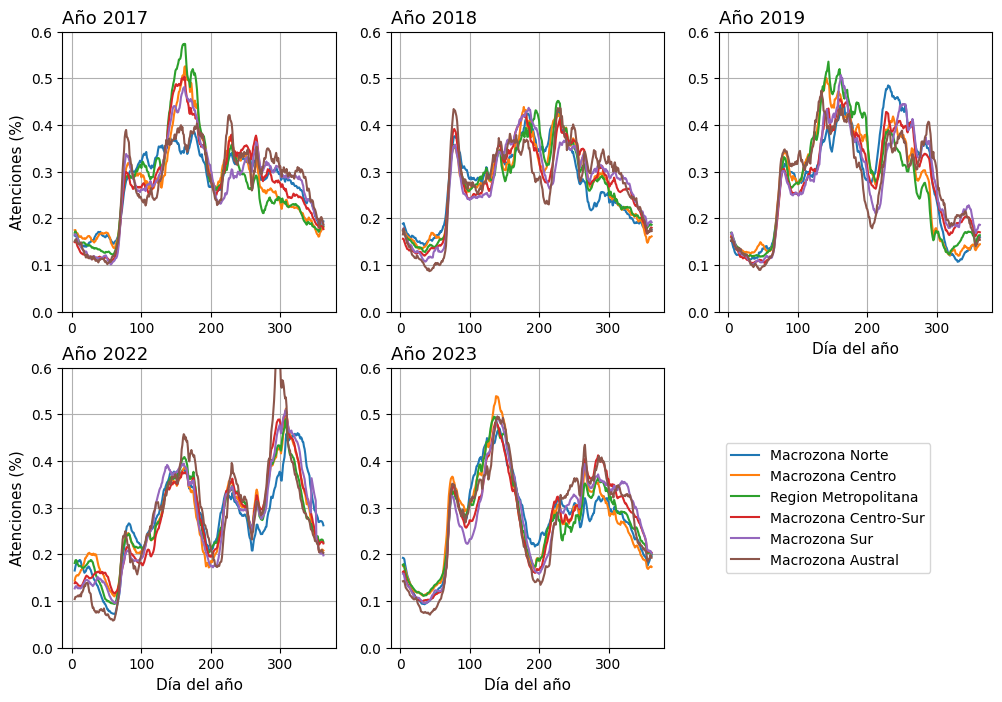

In [3]:
#Genera una comparación de las atenciones diarias correspondiente 
# a diferentes regiones geográficas. Las zonas están determinadas 
# por lo servicios de salud que las componen
# en los gráficos se muestra la información para diferentes años

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
query_list = []
for k, servicios_zona, nombre_zona in zip([k for k in range(len(lista_zonas_servicios_salud))],lista_zonas_servicios_salud,lista_zonas):
    query_list.append("""
SELECT year(strptime(fecha, '%d/%m/%Y')) as year
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia 
    ,""" + "'"  + nombre_zona + "'" + """ as zona
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
and CodigoDependencia in """ + servicios_zona +"""
group by zona, fecha
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
""")
    if k +1< len(lista_zonas_servicios_salud):
        query_list.append(""" UNION """)

df2 = duckdb.sql(''.join(query_list)).df()

df2 = df2.sort_values(by=['zona','year','nrodia']).reset_index(drop = True)

fig = plt.figure(figsize = (12,8))

for k in range(5):
    df3 =df2[df2["year"]==year_list[k]]
    ax = fig.add_subplot(2,3,k+1) 
    df_dict = {key[0]: d for key, d in df3[['zona','year','nrodia','atenciones']].groupby(['zona'])}
    #targets = list(df_dict.keys())
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for key in lista_zonas:
        plt.plot(df_dict[key]['nrodia'],100*df_dict[key]['atenciones'].rolling(7,center=True).mean()/float(sum(df_dict[key]['atenciones'])) )
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.6)
    ax.grid()
    ax.set_title('Año ' + str(year_list[k]) , fontsize = 13, loc='left')
    if k in (2,3,4):
       ax.set_xlabel('Día del año', fontsize = 11)
    if k in (0,3):
        ax.set_ylabel('Atenciones (%)', fontsize = 11)

#show legend in last plot space
ax = fig.add_subplot(2,3,6) 
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for key in lista_zonas:
    plt.plot(range(1),range(1))

ax.legend(lista_zonas_legend,loc='center left',fontsize = 10 )
ax.axis('off')
plt.savefig('fig3_v2_urgencias_geografica_años.png', bbox_inches='tight')


